# Brain Tumor Classification using QCNN and CNN model

In [1]:
# QML
import pennylane as qml

# CML
import tensorflow as tf
from tensorflow import keras as K

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split


# for evaluation
from sklearn.metrics import classification_report
import itertools

# calculus
from pennylane import numpy as np


## Data Analysis

In this section we are going to introduce the used dataset and do some visualization in order to explore its contents

### About the dataset

The dataset has been downloaded from figshare website [link](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)

It is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    - cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    - cjdata.PID: patient ID
    - cjdata.image: image data
    - cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
            - For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
            - It was generated by manually delineating the tumor border. So we can use it to generate
            - binary image of tumor mask.
    - cjdata.tumorMask: a binary image with 1s indicating tumor region

### Visualize the data

#### Labels

In [2]:
# Counting labels
folder = "./brain_tumor_dataset/all/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
for file in directs:
    f = h5py.File('./brain_tumor_dataset/all/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(3064,)

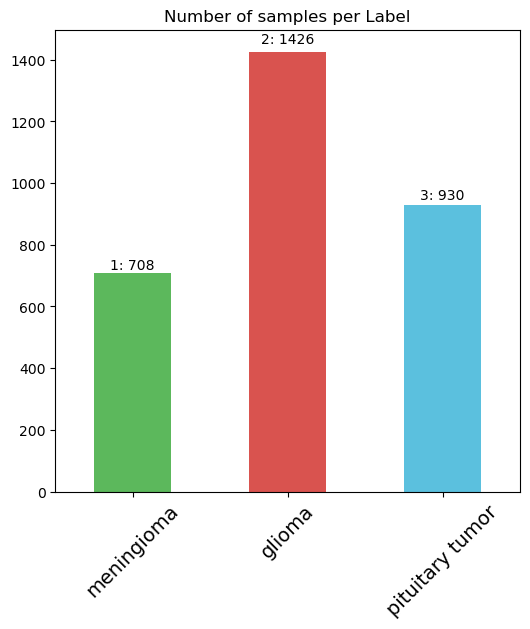

In [3]:
# Tumor types
names = ["meningioma", "glioma", "pituitary tumor"]
# Count labels
labelcounts = labels.value_counts().sort_index()
# change the index with th types
labelcounts.index = names

#print(labelcounts)

# create a barchart
ax = labelcounts.plot(
        kind='bar',
        figsize=(6, 6),
        width=0.5,
        color=['#5cb85c', '#d9534f', '#5bc0de'],
     )

# define the title
ax.set_title("Number of samples per Label", size=12)
# change font size for labells an legend
plt.xticks(fontsize=14, rotation=45)

# putting the numbers
i = 1
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(i)+": "+str(height), (x + width/2, y + height*1.02), ha='center')
    i += 1


#### Pictures

In [4]:
folder = "./brain_tumor_dataset/all/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
images = []
masks = []
for file in directs:
    f = h5py.File(folder+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    if label not in labels:
        #print(file)
        labels.append(label)
        img = np.stack((np.array(f.get("cjdata/image")),)*4, axis=-1)
        images.append(img)
        mask = np.array(f.get("cjdata/tumorMask"))
        masks.append(mask)
labels = np.asarray(labels)
images = np.asarray(images)
masks = np.asarray(masks)
labels.shape, images.shape, masks.shape

((3,), (3, 512, 512, 4), (3, 512, 512))

In [5]:
b = K.utils.to_categorical(masks, num_classes=4).astype(np.uint8)
tumor = np.zeros_like(images[:, :, :, 1:])
image_norm = cv2.normalize(images[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

print(image_norm.shape)

# remove tumor part from image
tumor[:, :, :, 0] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 1] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 2] = image_norm * (b[:, :, :, 0])

# color tumor
tumor += b[:, :, :, 1:] * 255

tumor.shape

(3, 512, 512)


(3, 512, 512, 3)

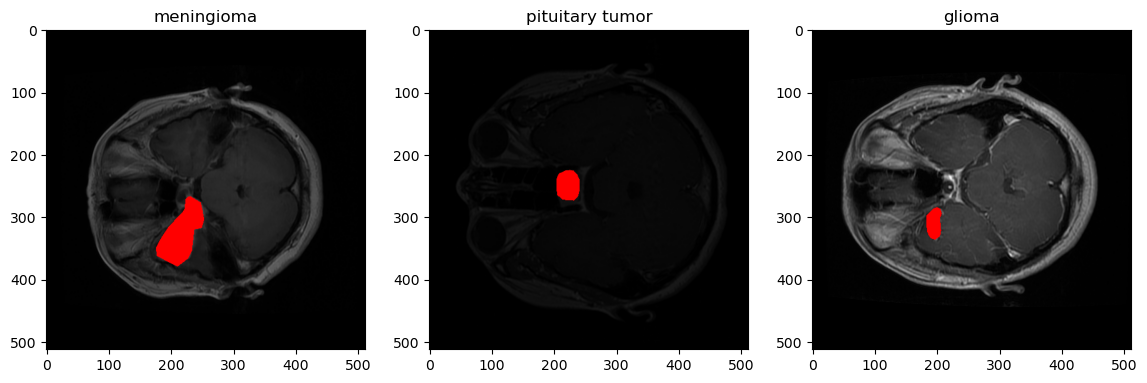

In [6]:
fig = plt.figure(figsize=(14, 10))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(tumor[i], "gray")
    plt.title(names[int(labels[i]-1)])

plt.show()

##  Model

In this section we will talk about our model and how we designed it

### Architecture

Resources

<hr>

[- CNN](https://www.researchgate.net/publication/331540139_A_State-of-the-Art_Survey_on_Deep_Learning_Theory_and_Architectures/figures?lo=1&utm_source=google&utm_medium=organic)
<br>
[- QCNN](https://arxiv.org/pdf/2009.09423.pdf)
<br>
[- Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_quanvolution.html?fbclid=IwAR3Sw-OvDokiY1bzltvyyLHnnlPvlVTnAiwH3HqjTYpLxnjSbibGBfaSmTA)

### First part: Features Extraction

<hr>
Defining Quantum Circuit and Quantum Convolutional function

In [8]:
wires=4

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[3, 2])
    qml.CRZ(theta, wires=[2, 0])
    qml.CRX(theta, wires=[2, 0])

    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=0))

    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    step2 = 2
    out = np.zeros(((H//step), (W//step)))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # get 2x2 pixels and make them 1D array
            phi = X[i:i+2, j:j+2].flatten()
            # Get Measurement
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out


<hr>
Visualizing Quantum Circuit

In [9]:
phi = [1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 4))

0: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╭RZ(1.57)─╭RX(1.57)─┤  <Z>
1: ──RX(3.14)─╰●────────╰●────────│─────────│─────────┤     
2: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╰●────────╰●────────┤     
3: ──RX(3.14)─╰●────────╰●────────────────────────────┤     


<hr>

Applying the Quantum Convolutional Layer

In [11]:
# Images processing with a Quantum Convolutional Layer after being resized
folder = "./brain_tumor_dataset/all/" # .mat files folder
processFolder = "./brain_tumor_dataset/processed/allresized/"
start = timer()
w = 512
step = 2

k = 0
directs = sorted(listdir(folder))

for file in directs:
    all64 = sorted(listdir(processFolder))
    if file+".npz" in all64:
        continue
    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    NorImages = resized/255

    processed = QCONV1(NorImages, str(k)+" "+file, (len(directs)-len(all64))/2, step)

    np.savez_compressed(processFolder+file, image=processed, label=label)
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

'9:41:14'

<hr>
Visualization after applying quantum filter

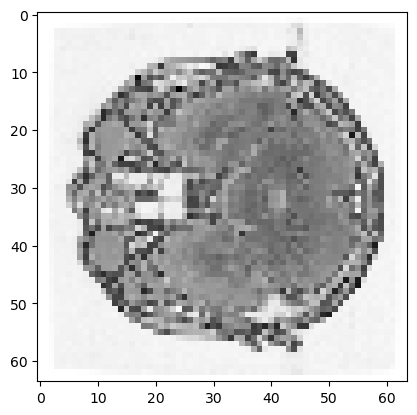

In [13]:
img = np.load("./brain_tumor_dataset/processed/allresized/1000.mat.npz")['image']
plt.imshow(img, "gray")
plt.show()


### Second part: Classification

<hr>
Get processed images coupled with their labels

In [14]:
# get processed data
folder = "./brain_tumor_dataset/processed/allresized/"
directs = sorted(listdir(folder))


images = []
masks = []
labels = []
i = 0
for file in directs:
    try:
        data = np.load(folder+file)
        label = data["label"]
        img = np.stack((data["image"],), axis=-1)
        images.append(img)
        labels.append(label)
        i+=1
    except:
        continue

npimages = np.asarray(images)
nplabels = np.asarray(labels)

In [16]:
npimages.shape, nplabels.shape

((3049, 64, 64, 1), (3049,))

<hr>

Splitting the data to 3 parts train/validation/test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [18]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((2134, 64, 64, 1),
 (458, 64, 64, 1),
 (457, 64, 64, 1),
 (457,),
 (2134,),
 (458,))

<hr>

Defining Fully Connected Layers with Tensorflow

In [23]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(128, activation="relu"),
        K.layers.Dropout(0.5),
        K.layers.Dense(4, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

<hr>

Train the model

In [26]:
### tf.random.set_seed(42)
q_model = Model()
checkpoint_path = "checkpoints/quantum.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=20,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/20
134/134 - 2s - 18ms/step - accuracy: 0.6312 - loss: 0.9312 - val_accuracy: 0.7593 - val_loss: 0.6108
Epoch 2/20
134/134 - 1s - 6ms/step - accuracy: 0.7390 - loss: 0.5943 - val_accuracy: 0.7921 - val_loss: 0.4628
Epoch 3/20
134/134 - 1s - 5ms/step - accuracy: 0.8018 - loss: 0.4754 - val_accuracy: 0.8009 - val_loss: 0.4502
Epoch 4/20
134/134 - 1s - 4ms/step - accuracy: 0.8004 - loss: 0.4435 - val_accuracy: 0.7746 - val_loss: 0.4559
Epoch 5/20
134/134 - 1s - 4ms/step - accuracy: 0.8351 - loss: 0.3956 - val_accuracy: 0.8425 - val_loss: 0.4148
Epoch 6/20
134/134 - 1s - 4ms/step - accuracy: 0.8435 - loss: 0.3650 - val_accuracy: 0.8468 - val_loss: 0.4133
Epoch 7/20
134/134 - 1s - 4ms/step - accuracy: 0.8590 - loss: 0.3150 - val_accuracy: 0.8425 - val_loss: 0.4034
Epoch 8/20
134/134 - 1s - 4ms/step - accuracy: 0.8707 - loss: 0.3078 - val_accuracy: 0.8446 - val_loss: 0.3936
Epoch 9/20
134/134 - 1s - 5ms/step - accuracy: 0.8585 - loss: 0.3180 - val_accuracy: 0.8512 - val_loss: 0.3657


In [27]:
q_model.save('QModel.h5')

<hr>

Plotting the results

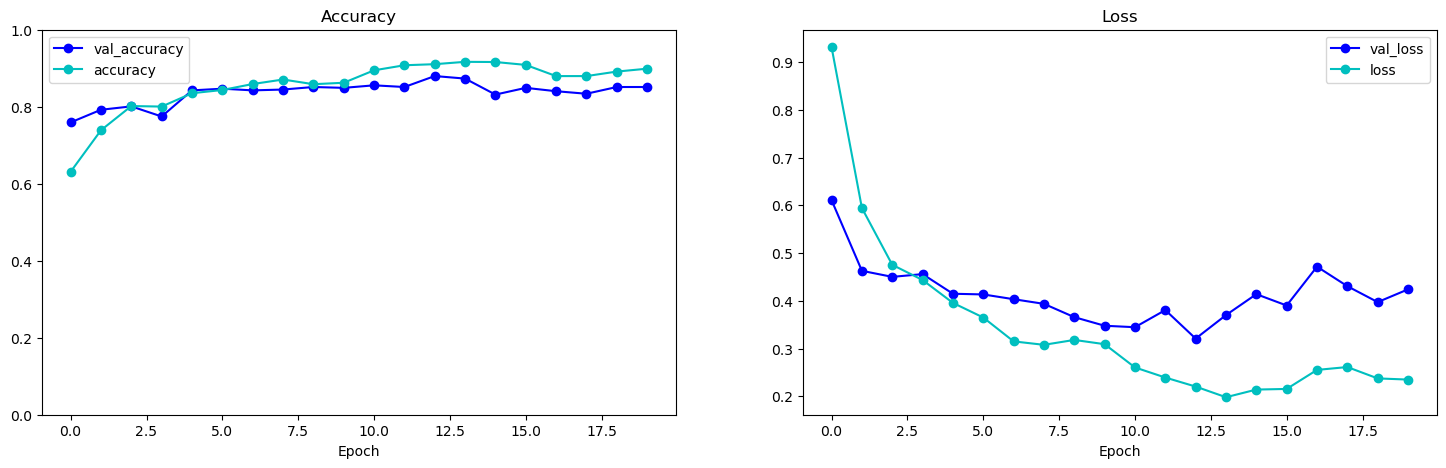

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(q_history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(q_history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

## Evaluation
<hr>

Defining a method to plot the Confusion Matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
# Get Saved Model
q_model = K.models.load_model('QModel.h5')

<hr>
Get predicted labels

In [32]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [33]:
yhat.shape, y_test.shape

((458,), (458,))

<hr>

Printing the classification report using Sklearn

In [34]:
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

         1.0       0.90      0.57      0.70       113
         2.0       0.83      0.96      0.89       213
         3.0       0.92      0.98      0.95       132

    accuracy                           0.87       458
   macro avg       0.88      0.83      0.84       458
weighted avg       0.87      0.87      0.86       458



<hr>

Computing & Plotting Confusion Matrix

Confusion matrix, without normalization


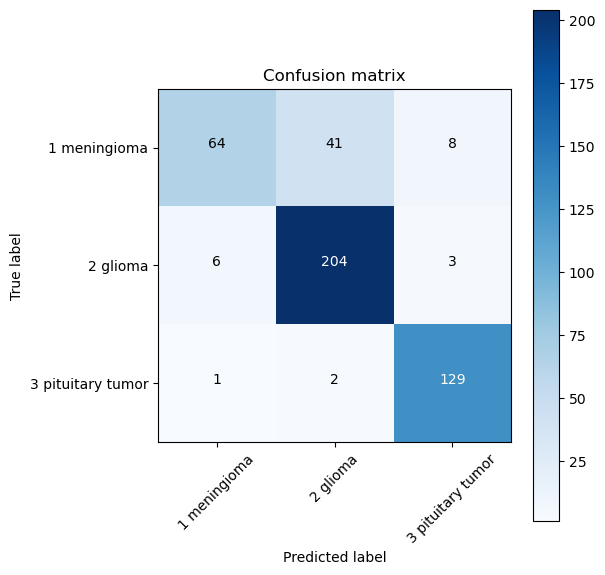

In [35]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

# DenseNet121

In [36]:
# Images resizing
folder = "./brain_tumor_dataset/all/" # .mat files folder

w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
images = []
labels = []

for file in directs:

    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue

    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    images.append(np.stack((resized,), axis=-1))
    labels.append(label)
    print("image "+str(k)+"  ", end="\r")

    k+=1
images = np.asarray(images)/255
labels = np.asarray(labels)

In [37]:
images.shape

(3049, 128, 128, 1)

<hr>

Splitting the data to 3 parts train/validation/test

In [38]:
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2134, 128, 128, 1), (458, 128, 128, 1), (2134,), (458,))

<hr>

Defining the DenseNet121 Model & Training it



In [41]:
# create DenseNet121 Model
model = K.applications.DenseNet121(
    weights=None,
    input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
    classes=4,
)
# compile the model
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)
checkpoint_path = "checkpoints/classical.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=20,
    verbose=1,
    callbacks=[cp_callback]
)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 183s 874ms/step - accuracy: 0.6043 - loss: 0.9208 - val_accuracy: 0.4083 - val_loss: 2.4761
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.7456 - loss: 0.5909 - val_accuracy: 0.7489 - val_loss: 0.6257
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.7346 - loss: 0.5939 - val_accuracy: 0.7555 - val_loss: 0.5441
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7855 - loss: 0.5195 - val_accuracy: 0.7402 - val_loss: 0.6095
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 661s 5s/step - accuracy: 0.7771 - loss: 0.4683 - val_accuracy: 0.8253 - val_loss: 0.4266
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 686s 5s/step - accuracy: 0.8132 - loss: 0.4174 - val_accuracy: 0.8079 - val_loss: 0.4717
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 1007s 8s/step - accuracy: 0.8506 - loss: 0.3591 - val_accuracy: 0.6245 - val_loss: 8.6168
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 971s 7s/step - accuracy: 0.8413 - loss: 0.3701 - val_

<hr>

Save the Model

In [42]:
model.save('DenseNet121.h5')

<hr>

Plotting the results

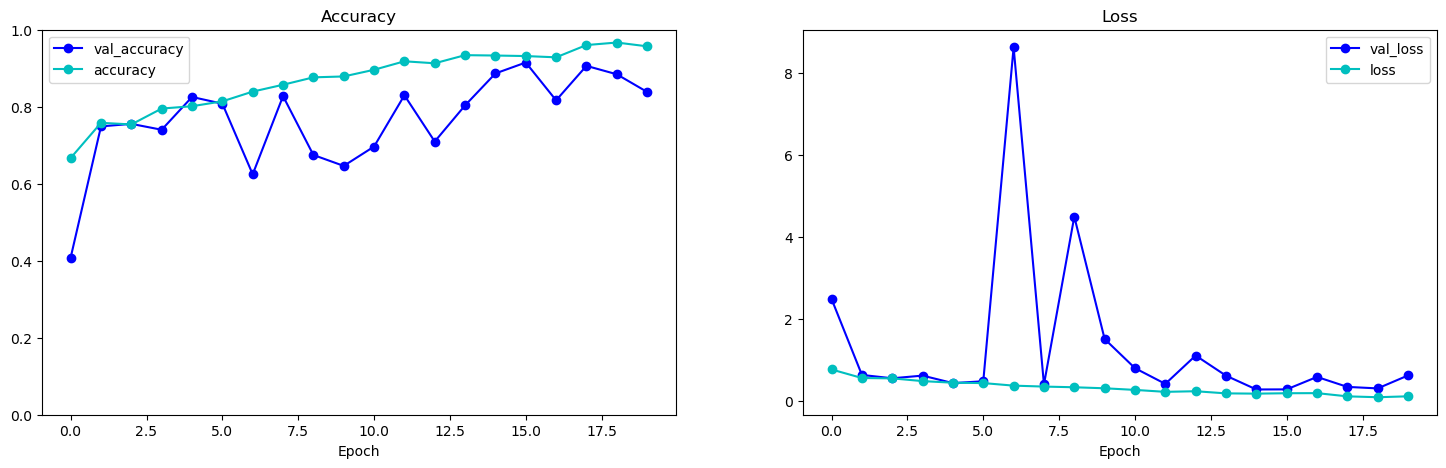

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

##  Evaluation
<hr>

Get Predicted labels

In [44]:
# Get Saved Model
model = K.models.load_model('DenseNet121.h5')

In [45]:
yhat = model.predict(X_test)
yhat = yhat.argmax(axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step


<hr>

Printing the classification report using Sklearn

In [46]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.95      0.48      0.64       113
         2.0       0.77      0.99      0.86       213
         3.0       0.94      0.91      0.92       132

    accuracy                           0.84       458
   macro avg       0.88      0.79      0.81       458
weighted avg       0.86      0.84      0.82       458



<hr>

Computing & Plotting Confusion Matrix

Confusion matrix, without normalization


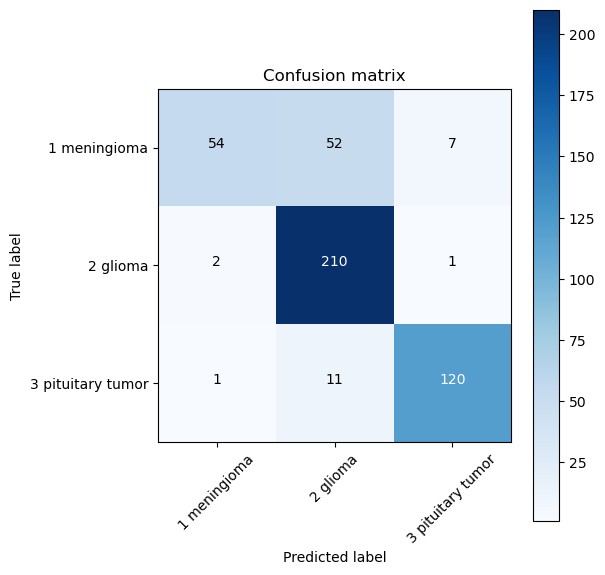

In [47]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

## ResNet50V2

In [11]:
import os
import numpy as np
import h5py
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [12]:
# Load and preprocess dataset
folder = "./brain_tumor_dataset/all/"  # .mat files folder

images = []
labels = []
k = 0
directs = sorted(os.listdir(folder))

for file in directs:
    f = h5py.File(folder + file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue

    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Resize image
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    # Convert single channel to three channels
    resized = np.stack((resized,) * 3, axis=-1)

    images.append(resized)
    labels.append(label)
    print("Processing image " + str(k), end="\r")

    k += 1

images = np.asarray(images) / 255.0
labels = np.asarray(labels)

In [13]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [14]:
# Create the custom ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification
model = Model(inputs=base_model.input, outputs=x)

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Create a callback that saves the model's weights
checkpoint_path = "checkpoints/resnet50v2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [17]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=16, epochs=20, verbose=1, callbacks=[cp_callback])

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.6960 - loss: 0.7180 - val_accuracy: 0.8337 - val_loss: 0.4695
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9376 - loss: 0.1905 - val_accuracy: 0.9409 - val_loss: 0.2053
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9550 - loss: 0.1119 - val_accuracy: 0.9322 - val_loss: 0.2649
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 126s 942ms/step - accuracy: 0.9814 - loss: 0.0611 - val_accuracy: 0.9322 - val_loss: 0.2121
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 106s 789ms/step - accuracy: 0.9732 - loss: 0.0836 - val_accuracy: 0.9540 - val_loss: 0.1736
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 129s 962ms/step - accuracy: 0.9869 - loss: 0.0432 - val_accuracy: 0.9125 - val_loss: 0.2783
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 99s 738ms/step - accuracy: 0.9828 - loss: 0.0435 - val_accuracy: 0.9453 - val_loss: 0.2088
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 100s 745ms/step - accuracy: 0.9806 - loss: 0.0

In [18]:
# Save the model
model.save('ResNet50V2_custom.h5')

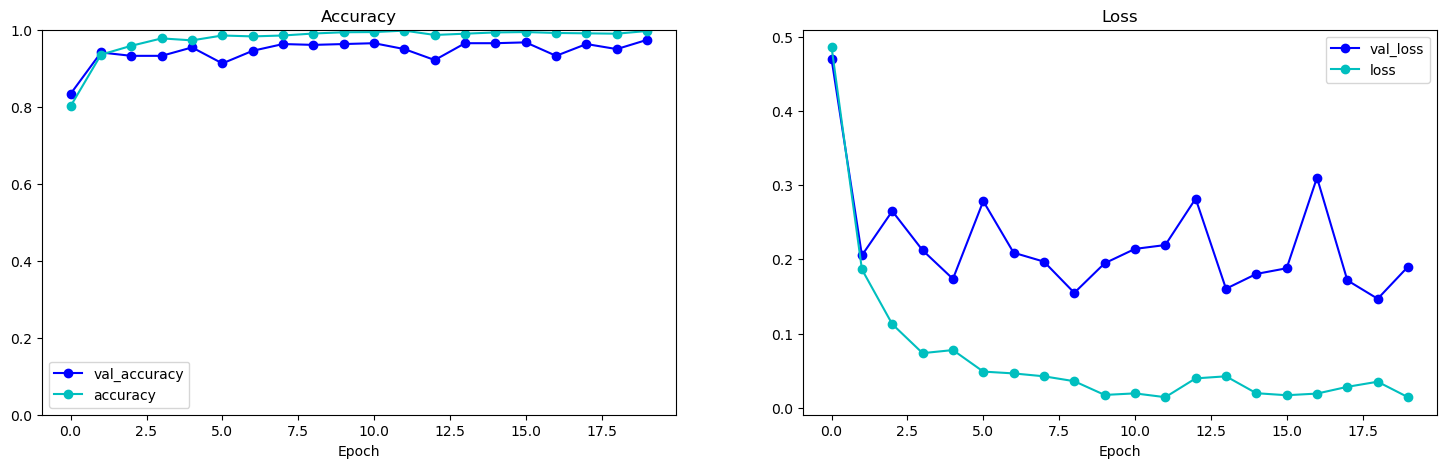

In [19]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

In [20]:
# Load the saved model
model = tf.keras.models.load_model('ResNet50V2_custom.h5')

In [21]:
# Make predictions
yhat = model.predict(X_test)
yhat = yhat.argmax(axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step


In [22]:
# Print classification report
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       1.00      0.85      0.92       113
         2.0       0.96      1.00      0.98       213
         3.0       0.95      1.00      0.97       132

    accuracy                           0.96       458
   macro avg       0.97      0.95      0.96       458
weighted avg       0.96      0.96      0.96       458



In [23]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

In [25]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


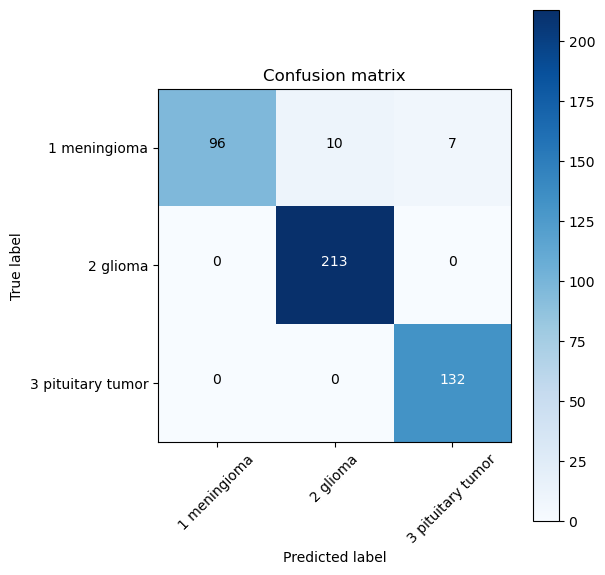

In [27]:
import itertools
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False, title='Confusion matrix')
plt.show()